In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import reciprocal
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve, make_scorer
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from skopt import gp_minimize
from skopt.space import Real, Categorical
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [34]:
processed_train_data=pd.read_csv('../data/processed data/processed_train_data.csv', encoding='ISO-8859-1')
processed_test_data=pd.read_csv('../data/processed data/processed_val_data.csv', encoding='ISO-8859-1')

In [35]:
X_train=processed_train_data.drop('target', axis=1)
y_train=processed_train_data['target']
X_test=processed_test_data.drop('target',axis=1)
y_test=processed_test_data['target']

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((505612, 3), (216619, 3), (505612,), (216619,))

In [37]:
X_train.head(), y_train.head()

(                                                text  polarity  contains_not
 0  really bore nothing not want tomoz lazy nothin... -0.656250             1
 1  run hrs sleep whoo hoo lol come around head ho...  1.000000             0
 2  think reality finally set nowin day half heart... -0.153472             0
 3                              explore twitter world  0.000000             0
 4                                  hungover make day  0.000000             0,
 0    0
 1    1
 2    0
 3    1
 4    0
 Name: target, dtype: int64)

# Features for models

## Bag of words

In [6]:
count_vectorizer = CountVectorizer(max_df=0.8)
count_train = count_vectorizer.fit_transform(X_train['text']).astype('float32')
count_test = count_vectorizer.transform(X_test['text']).astype('float32')

## TF-IDF

In [38]:
tfidf = TfidfVectorizer(norm='l2')
tfidf_vector_train=tfidf.fit_transform(X_train['text'])
tfidf_vector_test = tfidf.transform(X_test['text'])

tfidf_biagrams = TfidfVectorizer(ngram_range=(1, 2),norm='l2')
tfidf_biagrams_vector_train=tfidf_biagrams.fit_transform(X_train['text'])
tfidf_biagram_vector_test = tfidf_biagrams.transform(X_test['text'])


tfidf_trigrams = TfidfVectorizer(ngram_range=(1, 3),norm='l2')
tfidf_trigrams_vector_train=tfidf_trigrams.fit_transform(X_train['text'])
tfidf_trigrams_vector_test = tfidf_trigrams.transform(X_test['text'])

In [39]:
print(tfidf_vector_train)

  (0, 50931)	0.31352684174137296
  (0, 82647)	0.23266635722882933
  (0, 79371)	0.3622244908924406
  (0, 144657)	0.4650906585220032
  (0, 155327)	0.19125824123932605
  (0, 99000)	0.12743938740434393
  (0, 99090)	0.5700679234159668
  (0, 17910)	0.276934396103799
  (0, 115796)	0.21344969879975353
  (1, 30657)	0.2936496196756181
  (1, 95247)	0.2961765890801822
  (1, 58527)	0.24278231045931017
  (1, 64368)	0.19335152733216548
  (1, 61352)	0.23712170188258969
  (1, 7973)	0.26071005898521393
  (1, 28385)	0.19264203330271082
  (1, 82126)	0.19063176577744953
  (1, 64887)	0.3594132389115824
  (1, 158279)	0.41324509555658345
  (1, 128743)	0.2017864126421686
  (1, 65966)	0.3573677300382783
  (1, 120471)	0.2523778317665004
  (2, 91729)	0.233639827137946
  (2, 10862)	0.2215796981934975
  (2, 90271)	0.1507237524489683
  :	:
  (505609, 52601)	0.26382387436537597
  (505609, 81346)	0.2432440228958278
  (505609, 160224)	0.14863428697180106
  (505609, 55845)	0.1416464919746426
  (505610, 161988)	0.5444313

## Word Embeddings

In [8]:
tokenized_sentences = [word_tokenize(text) for text in X_train['text']]

model = Word2Vec(tokenized_sentences, vector_size=100, window=7, min_count=5, sg=1)

def text_to_vector(text, embedding_model, embedding_dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in embedding_model.wv:
            vectors.append(embedding_model.wv[word])
    if not vectors:
        return np.zeros(embedding_dim)
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector

embedding_dim = 10

word2vec_vector = X_train['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))
word2vec_vector_test = X_test['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))

In [9]:
max_length = 100

def pad_or_truncate_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = np.pad(seq, (0, max_length - len(seq)), mode='constant')
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

X_train_w2v_pad = pad_or_truncate_sequences(word2vec_vector, max_length)
X_test_w2v_pad = pad_or_truncate_sequences(word2vec_vector_test, max_length)

# Basic Models

In [41]:
numeric_features = ['contains_not', 'polarity']
text_feature = 'text'

In [42]:
def model_classification_reports(models, X_train, y_train, X_test, y_test):
    reports = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_pred)
        report['roc_auc'] = roc_auc
        reports[model_name] = report
    return reports

In [43]:
def print_classification_reports(reports):
    for model_name, report in reports.items():
        print(model_name.upper())
        print('==================================')

        print('Model Performance for Test Set:')
        print('- Accuracy: {:.4f}'.format(report['accuracy']))
        print('- F1 Score: {:.4f}'.format(report['weighted avg']['f1-score']))
        print('- Precision: {:.4f}'.format(report['weighted avg']['precision']))
        print('- Recall: {:.4f}'.format(report['weighted avg']['recall']))
        print('- ROC AUC Score: {:.4f}'.format(report['roc_auc']))

        print('==================================')
        print('\n')


### bag of words

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', CountVectorizer(max_df=0.8), text_feature)])

In [45]:
models_to_test = {
    'LinearSVC': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LinearSVC())]),
    'LogisticRegression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())]),
    'LGBMClassifier': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LGBMClassifier())]),
    'XGBClassifier': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(objective='binary:logistic',
                                   eval_metric='logloss',
                                   n_estimators=100,
                                   max_depth=5))] ),
    'DecisionTreeClassifier': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      min_samples_leaf=5,
                                                      max_features='sqrt',
                                                      criterion='gini'))])
}

reports = model_classification_reports(models_to_test, X_train, y_train, X_test, y_test)
print_classification_reports(reports)


[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.029767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23811
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 9847
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
LINEARSVC
Model Performance for Test Set:
- Accuracy: 0.8245
- F1 Score: 0.8141
- Precision: 0.8130
- Recall: 0.8245
- ROC AUC Score: 0.7096


LOGISTICREGRESSION
Model Performance for Test Set:
- Accuracy: 0.8319
- F1 Score: 0.8209
- Precision: 0.8212
- Recall: 0.8319
- ROC AUC Score: 0.7161


LGBMCLASSIFIER
Model Performance for Test Set:
- Accuracy: 0.8176
- F1 Score: 0.7959
- Precision: 0.8046
- Recall: 0.8176
- ROC AUC Score: 0

### Bayes optimization for Logistic Regression

In [16]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

space = [
    Real(1e-6, 100.0, name='classifier__C'),
    Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], name='classifier__solver')
]

def objective(params):
    model.set_params(**{'classifier__C': params[0], 'classifier__solver': params[1]})
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    roc_auc = roc_auc_score(y_train, y_pred_proba)
    return -roc_auc

n_calls = 20
with tqdm(total=n_calls, desc="Optimizing", position=0) as pbar:
    result = gp_minimize(objective, space, n_calls=n_calls, random_state=42, callback=lambda _: pbar.update(1))

best_params = result.x
best_score = -result.fun
print("Best parameters:", best_params)
print("Best ROC AUC:", best_score)


Optimizing:   5%|███▍                                                                | 1/20 [06:10<1:57:13, 370.20s/it]

Best parameters: [79.65429888948032, 'newton-cg']
Best ROC AUC: 0.9422327926699563


In [17]:
best_C = 79.65429888948032
best_solver = 'newton-cg'

best_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(C=best_C, solver=best_solver, class_weight='balanced'))])

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7729192730092929
Precision: 0.5143648030868598
Recall: 0.7179627280710313
F1 Score: 0.5993451382214475
ROC AUC: 0.8167890775745943
Confusion Matrix:
[[130637  34737]
 [ 14453  36792]]


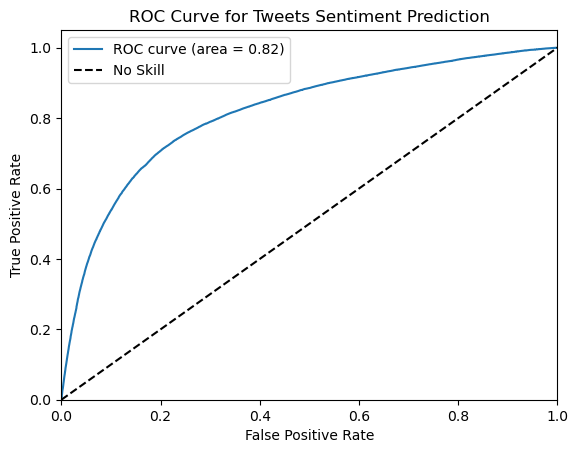

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure() 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tweets Sentiment Prediction')
plt.legend()
plt.show()

### tfidf trigrams models

In [21]:
tfidf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(ngram_range=(1, 3)), text_feature)])

In [20]:
models_to_test = {
    'LinearSVC': Pipeline(steps=[('preprocessor', tfidf_preprocessor), ('classifier', LinearSVC())]),
    'LogisticRegression': Pipeline(steps=[('preprocessor', tfidf_preprocessor), ('classifier', LogisticRegression())]),
    'LGBMClassifier': Pipeline(steps=[('preprocessor', tfidf_preprocessor), ('classifier', LGBMClassifier())]),
    'XGBClassifier': Pipeline(steps=[('preprocessor', tfidf_preprocessor), ('classifier', XGBClassifier(objective='binary:logistic',
                                   eval_metric='logloss',
                                   n_estimators=100,
                                   max_depth=5))] ),
    'DecisionTreeClassifier': Pipeline(steps=[('preprocessor', tfidf_preprocessor), ('classifier', DecisionTreeClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      min_samples_leaf=5,
                                                      max_features='sqrt',
                                                      criterion='gini'))])
}

tfidf_reports = model_classification_reports(models_to_test, X_train, y_train, X_test, y_test)
print_classification_reports(tfidf_reports)


[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 73.140839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409868
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 29111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
LINEARSVC
Model Performance for Test Set:
- Accuracy: 0.8417
- F1 Score: 0.8347
- Precision: 0.8335
- Recall: 0.8417
- ROC AUC Score: 0.7439


LOGISTICREGRESSION
Model Performance for Test Set:
- Accuracy: 0.8419
- F1 Score: 0.8329
- Precision: 0.8331
- Recall: 0.8419
- ROC AUC Score: 0.7350


LGBMCLASSIFIER
Model Performance for Test Set:
- Accuracy: 0.8198
- F1 Score: 0.8007
- Precision: 0.8069
- Recall: 0.8198
- ROC AUC Score:

### Linear SVC for TF-IDF

In [21]:
l_SVC=LinearSVC()
l_SVC.fit(tfidf_vector_train,y_train)

LinearSVC()

In [22]:
y_pred_test = l_SVC.predict(tfidf_vector_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.856212,0.934065,0.893445,165374.000000
1,0.698851,0.493785,0.578688,51245.000000
accuracy,0.829909,0.829909,0.829909,0.829909
macro avg,0.777531,0.713925,0.736067,216619.000000
weighted avg,0.818985,0.829909,0.818984,216619.000000


### Using trigrams

In [48]:
l_SVC_trigrams=LinearSVC(class_weight='balanced')
l_SVC_trigrams.fit(tfidf_trigrams_vector_train,y_train)

LinearSVC(class_weight='balanced')

In [24]:
y_pred_trigrams_test = l_SVC_trigrams.predict(tfidf_trigrams_vector_test)
report = classification_report(y_test, y_pred_trigrams_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.893035,0.880048,0.886494,165374.000000
1,0.630252,0.659830,0.644702,51245.000000
accuracy,0.827951,0.827951,0.827951,0.827951
macro avg,0.761643,0.769939,0.765598,216619.000000
weighted avg,0.830869,0.827951,0.829294,216619.000000


### Bayes optimization for LinearSVC

In [49]:
#TO RUN

tfidf_model = Pipeline(steps=[('preprocessor', tfidf_preprocessor),
                        ('classifier', LinearSVC())])

opt = BayesSearchCV(
    estimator=tfidf_model,
    search_spaces={
        #'classifier__C': reciprocal(0.001, 1000),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__dual': [False],
        'classifier__tol': [1e-3, 1e-4, 1e-5],
        'classifier__max_iter': [1000, 2000, 3000]
    },
    n_iter=5, #20
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train, y_train)
print("Best parameters:", opt.best_params_)
print("Best ROC AUC:", opt.best_score_)


ValueError: Found input variables with inconsistent numbers of samples: [3, 404489]

### Hyperparameters for LinearSVC
using trigrams tfidf vectors

In [54]:
#RandomGridSearch

param_grid = {
    'C': reciprocal(0.1, 10), #0.001, 1000
    'penalty': ['l1', 'l2'],
    'dual': [False],
    'tol': [1e-3, 1e-4], #1e-3, 1e-4, 1e-5
    'max_iter': [1000] # 1000, 2000, 3000
}

#small_tfidf_trigrams_vector_train = tfidf_trigrams_vector_train
#small_y_train = y_train

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

random = RandomizedSearchCV(estimator=l_SVC_trigrams, param_distributions=param_grid,
                            cv=3, n_jobs=-1, n_iter=5, scoring=roc_auc_scorer)

with tqdm(total=5, desc="Random Grid Search") as pbar:
    random_result = random.fit(tfidf_biagrams_vector_train, y_train)
    pbar.update(1)

print("Best ROC AUC score: %f using %s" % (random_result.best_score_, random_result.best_params_))

Random Grid Search:  20%|████████████▌                                                  | 1/5 [09:17<37:11, 557.91s/it]

Best ROC AUC score: 0.788498 using {'C': 0.311954562091293, 'dual': False, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}


In [ ]:
best_model=random_result.best_estimator_
best_model.score(X_test, y_test)
#coś nie działa nie wiem czemu

In [27]:
param_grid = {'C': [0.1, 1, 10]}

linearSVC_grid = GridSearchCV(LinearSVC(), param_grid, refit=True, verbose=3)
linearSVC_grid.fit(tfidf_trigrams_vector_train, y_train)

print("Tuned hyperparameters (best parameters): ", linearSVC_grid.best_params_)
print("Accuracy:", linearSVC_grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.833 total time=   5.8s
[CV 2/5] END .............................C=0.1;, score=0.833 total time=   5.5s
[CV 3/5] END .............................C=0.1;, score=0.833 total time=   3.9s
[CV 4/5] END .............................C=0.1;, score=0.833 total time=   3.5s
[CV 5/5] END .............................C=0.1;, score=0.832 total time=   4.5s
[CV 1/5] END ...............................C=1;, score=0.839 total time=  15.3s
[CV 2/5] END ...............................C=1;, score=0.840 total time=  13.9s
[CV 3/5] END ...............................C=1;, score=0.838 total time=  12.3s
[CV 4/5] END ...............................C=1;, score=0.839 total time=  12.2s
[CV 5/5] END ...............................C=1;, score=0.839 total time=  13.0s
[CV 1/5] END ..............................C=10;, score=0.828 total time= 2.8min
[CV 2/5] END ..............................C=10;,

## Logistic Regression

In [28]:
lr=LogisticRegression(solver='sag')
lr.fit(tfidf_vector_train,y_train)
print(f"Train Accuracy: {lr.score(tfidf_vector_train, y_train) * 100:.3f}%", )
print(f"Test Accuracy: {lr.score(tfidf_vector_test, y_test) * 100:.3f}%")

Train Accuracy: 85.609%
Test Accuracy: 83.695%


In [29]:
y_pred_train = lr.predict(tfidf_vector_test)
report = classification_report(y_test, y_pred_train, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.855416,0.946382,0.898603,165374.000000
1,0.736564,0.483794,0.584001,51245.000000
accuracy,0.836949,0.836949,0.836949,0.836949
macro avg,0.795990,0.715088,0.741302,216619.000000
weighted avg,0.827300,0.836949,0.824178,216619.000000


### Hyperparameters for logistic regression for TFIDF

In [ ]:
grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"], "solver": ["liblinear", "saga"]} # l1 lasso l2 ridge
logreg=LogisticRegression(max_iter=100)
logreg_cv=GridSearchCV(logreg,grid,cv=3,verbose=3,refit=True)
logreg_cv.fit(tfidf_vector_train,y_train)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.764 total time=   0.4s
[CV 2/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.764 total time=   0.5s
[CV 3/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.764 total time=   0.5s
[CV 1/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.764 total time=   5.0s
[CV 2/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.764 total time=   4.8s
[CV 3/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.764 total time=   4.8s
[CV 1/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.764 total time=   0.6s
[CV 2/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.764 total time=   0.6s
[CV 3/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.764 total time=   0.6s
[CV 1/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.764 total time=   4.9s
[CV 2/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.764 total time=   5.6s
[CV 3/3] END ..C=0.001, penalt

### Linear SVC for word embeddings

In [17]:
lsvc_word_embeddings = LinearSVC()

lsvc_word_embeddings.fit(X_train_w2v_pad, y_train)
y_pred_word_embeddings = lsvc_word_embeddings.predict(X_test_w2v_pad)
report_word_embeddings = classification_report(y_test, y_pred_word_embeddings, output_dict=True)
report_df_word_embeddings = pd.DataFrame(report_word_embeddings).transpose()

report_df_word_embeddings

,precision,recall,f1-score,support
0,0.824393,0.964916,0.889137,165374.0000
1,0.748352,0.336696,0.464435,51245.0000
accuracy,0.816300,0.816300,0.816300,0.8163
macro avg,0.786372,0.650806,0.676786,216619.0000
weighted avg,0.806404,0.816300,0.788666,216619.0000


### Logistic Regression for word embedding

In [75]:
lr_wordembedding=LogisticRegression(solver='sag')
lr_wordembedding.fit(X_train_w2v_pad,y_train)
print(f"Train Accuracy: {lr_wordembedding.score(X_train_w2v_pad, y_train) * 100:.3f}%", )
print(f"Test Accuracy: {lr_wordembedding.score(X_test_w2v_pad, y_test) * 100:.3f}%")

Train Accuracy: 81.851%
Test Accuracy: 81.819%


### Hyperparameters for logistic regression for Word Embeddings

In [76]:
grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"], "solver": ["liblinear", "saga"]}
logreg_wordembedding=LogisticRegression(max_iter=100)
logreg_cv_wordembedding=GridSearchCV(logreg_wordembedding,grid,cv=3,verbose=3,refit=True)
logreg_cv_wordembedding.fit(X_train_w2v_pad,y_train)

print("tuned hpyerparameters :(best parameters) ", logreg_cv_wordembedding.best_params_)
print("accuracy :",logreg_cv_wordembedding.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.789 total time=   4.7s
[CV 2/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.789 total time=   5.3s
[CV 3/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.788 total time=   4.2s
[CV 1/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.789 total time=  11.4s
[CV 2/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.789 total time=  11.3s
[CV 3/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.788 total time=  10.9s
[CV 1/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.802 total time=   3.9s
[CV 2/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.803 total time=   3.9s
[CV 3/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.801 total time=   3.7s
[CV 1/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.802 total time=   9.2s
[CV 2/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.802 total time=   9.6s
[CV 3/3] END ..C=0.001, penalt

### Random Forest for TFIDF

In [69]:
X_train_rf_1, _, y_train_rf_1, _ = train_test_split(tfidf_vector_train, y_train, test_size=0.5, random_state=42)

rf_model_1 = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
rf_model_1.fit(X_train_rf_1, y_train_rf_1)

y_pred_rf_1 = rf_model_1.predict(tfidf_vector_test)

accuracy_rf_1 = accuracy_score(y_test, y_pred_rf_1)
print("Accuracy Random Forest:", accuracy_rf_1)


Accuracy Random Forest: 0.8176291091732489


### Random Forest for word embeddings

In [74]:
X_train_rf_2, _, y_train_rf_2, _ = train_test_split(X_train_w2v_pad, y_train, test_size=0.5, random_state=42)

rf_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_2.fit(X_train_rf_2, y_train_rf_2)

y_pred_rf_2 = rf_model_2.predict(X_test_w2v_pad)

accuracy_rf_2 = accuracy_score(y_test, y_pred_rf_2)
print("Accuracy Random Forest:", accuracy_rf_2)


Accuracy Random Forest: 0.8115816248805506


In [63]:
# nie działa mi biblioteka torch

from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode_text(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0) 
    with torch.no_grad():
        outputs = model(input_ids)
    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states.numpy()

X_train_bert = [encode_text(text) for text in X_train['text']]
X_test_bert = [encode_text(text) for text in X_test['text']]

ModuleNotFoundError: No module named 'torch'

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_model = MultinomialNB()
nb_model.fit(tfidf_vector_train, y_train)

y_pred_nb = nb_model.predict(tfidf_vector_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Multinomial Naive Bayes:", accuracy_nb)


Accuracy Multinomial Naive Bayes: 0.7839063055410652


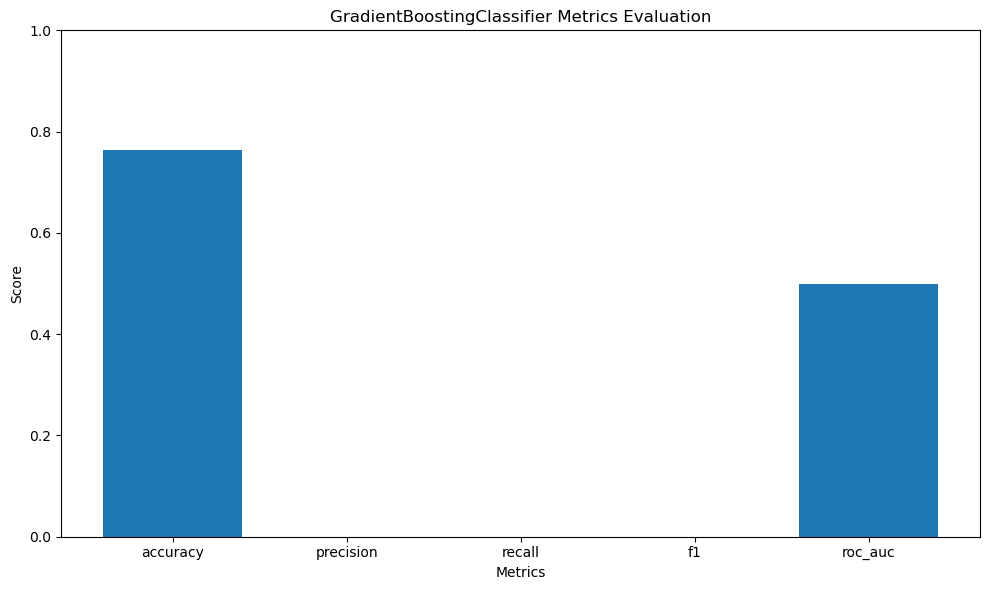

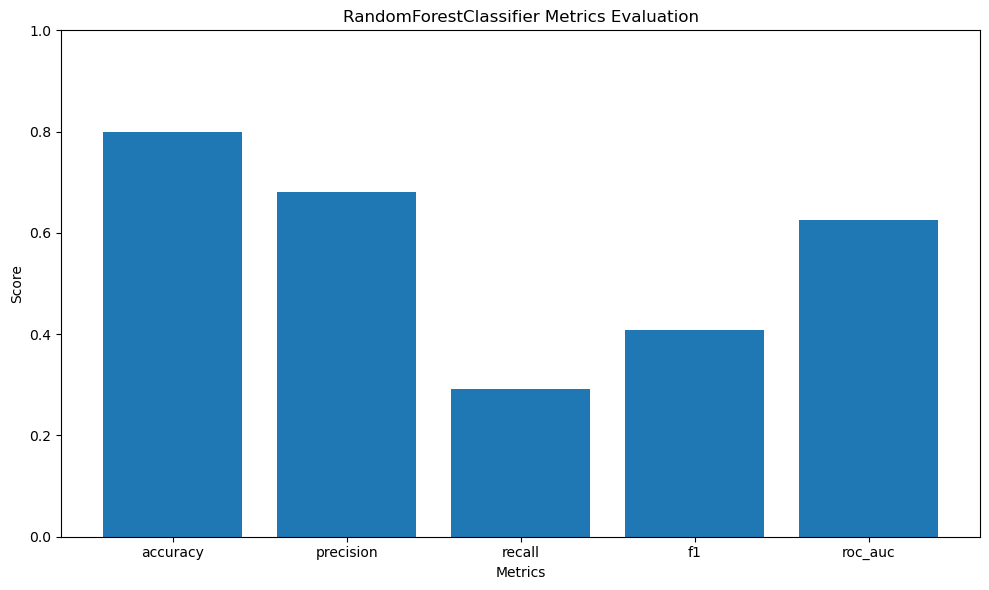

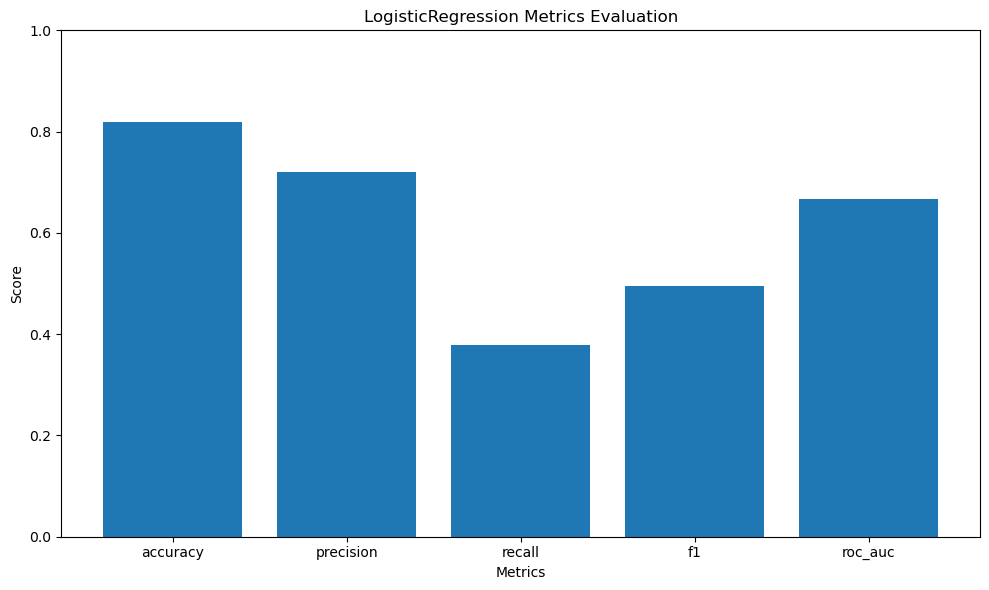

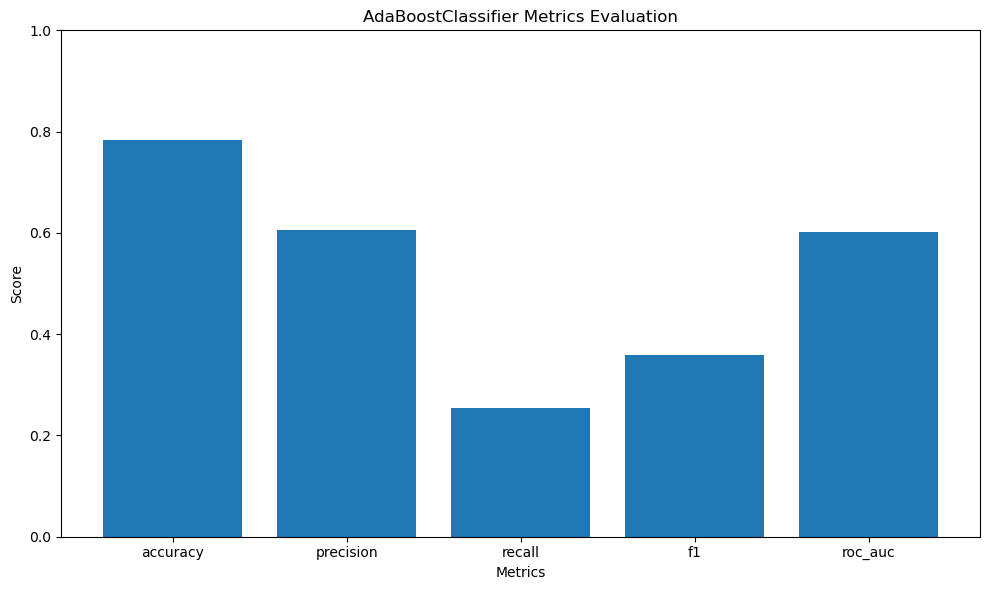

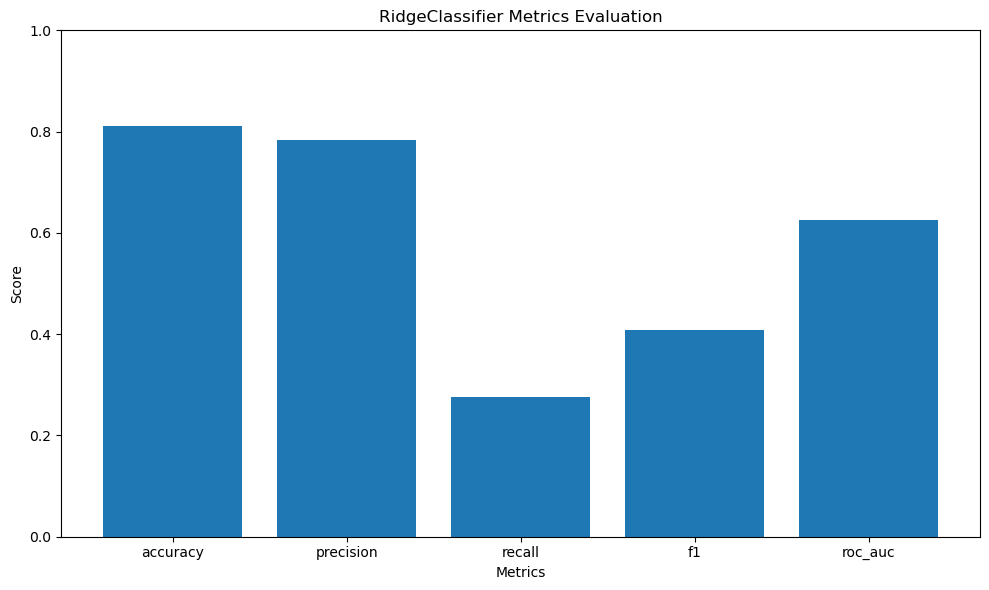

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

def evaluate_models(X_train, y_train, X_test, y_test, models, metrics):
    for model_name, model in models.items():
        model_results = {}
        for metric_name, metric_func in metrics.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = metric_func(y_test, y_pred)
            model_results[metric_name] = score
        
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(len(metrics)), list(model_results.values()), align='center')
        plt.xticks(np.arange(len(metrics)), list(model_results.keys()))
        plt.title(f'{model_name} Metrics Evaluation')
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1) 
        plt.tight_layout()
        plt.show()

models = {
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=3, max_depth=3),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1),
    'LogisticRegression': LogisticRegression(),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=10),
    'RidgeClassifier': RidgeClassifier(alpha=1.0),
    'LinearSVC': LinearSVC(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, criterion='gini'),
    'XGBClassifier': XGBClassifier(n_estimators=10)
}

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'roc_auc': roc_auc_score
}

evaluate_models(X_train_w2v_pad, y_train, X_test_w2v_pad, y_test, models, metrics)

